The objective of this project is to scrape baseball-reference.com and identify trends from the 2021 MLB season. More importantly, to identify which statistics/skillsets lead to success in modern professional baseball for teams with less spending power

Smaller market teams may need to build their rosters differently due to payroll constraints

Import all scraping/analytical/visualization libraries and tools:

In [1]:
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
import numpy as np

Create first BeautifulSoup Object

In [2]:
year = 2021
cat = "standard-batting"
url = 'https://www.baseball-reference.com/leagues/majors/{}-{}.shtml'.format(year, cat)
page_code = requests.get(url)
soup = BeautifulSoup(page_code.text, 'html.parser')


In [3]:
print(soup.prettify())


<!DOCTYPE html>
<html class="no-js" data-root="/home/br/build" data-version="klecko-" lang="en">
 <head>
  <meta charset="utf-8"/>
  <meta content="ie=edge" http-equiv="x-ua-compatible"/>
  <meta content="width=device-width, initial-scale=1.0, maximum-scale=2.0" name="viewport">
   <link href="https://cdn.ssref.net/req/202209082" rel="dns-prefetch"/>
   <!-- Quantcast Choice. Consent Manager Tag v2.0 (for TCF 2.0) -->
   <script async="true" type="text/javascript">
    (function() {
	var host = window.location.hostname;
	var element = document.createElement('script');
	var firstScript = document.getElementsByTagName('script')[0];
	var url = 'https://cmp.quantcast.com'
	    .concat('/choice/', 'XwNYEpNeFfhfr', '/', host, 
		    '/choice.js?tag_version=V2');
	var uspTries = 0;
	var uspTriesLimit = 3;
	element.async = true;
	element.type = 'text/javascript';
	element.src = url;
	
	firstScript.parentNode.insertBefore(element, firstScript);
	
	function makeStub() {
	    var TCF_LOCATOR_NAME

In [4]:
soup.find('tr')

<tr>
<th aria-label="Tm" class="poptip sort_default_asc left" data-stat="team_name" scope="col">Tm</th>
<th aria-label="#Bat" class="poptip center" data-stat="batters_used" data-tip="&lt;strong&gt;Number of Players used in Games&lt;/strong&gt;" scope="col">#Bat</th>
<th aria-label="BatAge" class="poptip sort_default_asc center" data-stat="age_bat" data-tip="&lt;strong&gt;Batters&amp;#x2019; average age&lt;/strong&gt;&lt;br&gt;Weighted by AB + Games Played" scope="col">BatAge</th>
<th aria-label="Runs Scored/Game" class="poptip center" data-stat="runs_per_game" data-tip="Runs Scored Per Game" scope="col">R/G</th>
<th aria-label="Games Played" class="poptip center" data-stat="G" data-tip="Games Played or Pitched" scope="col">G</th>
<th aria-label="Plate Appearances" class="poptip center" data-stat="PA" data-tip="&lt;strong&gt;Plate Appearances&lt;/strong&gt;&lt;br&gt;When available, we use actual plate appearances from play-by-play game accounts&lt;br&gt;Otherwise estimated using AB + BB

Team hitting categories:

In [5]:
team_stat_col = [x.getText() for x in soup.find_all('tr')[0].find_all('th') ]
team_stat_col = team_stat_col[1:]
print(team_stat_col)

['#Bat', 'BatAge', 'R/G', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB', 'LOB']


In [6]:
row = soup.find_all('tr')
team_stat = [[td.getText() for td in row[i].find_all('td')] for i in range(len(row))]
team_battingstats = pd.DataFrame(team_stat[1:], columns = team_stat_col)
pd.set_option('display.max_columns()', None)
team_names = [[td.getText() for td in row[i].find_all('a')] for i in range (len(row))]
team_names.extend([['League Average', 'Tm Totals', '']])
row_labels = []
for x in team_names:
    row_labels.extend(x)
team_battingstats.index=row_labels
print(team_battingstats)

                       #Bat BatAge   R/G     G      PA      AB      R      H  \
Arizona Diamondbacks     64   28.9  4.19   162    6144    5489    679   1297   
Atlanta Braves           56   28.2  4.91   161    6056    5363    790   1307   
Baltimore Orioles        62   26.7  4.07   162    5983    5420    659   1296   
Boston Red Sox           56   28.0  5.12   162    6122    5495    829   1434   
Chicago Cubs             69   29.1  4.35   162    5972    5306    705   1255   
Chicago White Sox        47   28.0  4.91   162    6084    5357    796   1373   
Cincinnati Reds          55   28.9  4.85   162    6162    5423    786   1352   
Cleveland Indians        48   26.7  4.43   162    5907    5332    717   1269   
Colorado Rockies         45   28.1  4.59   161    6007    5374    739   1338   
Detroit Tigers           49   28.1  4.30   162    5979    5376    697   1299   
Houston Astros           52   28.9  5.33   162    6291    5593    863   1496   
Kansas City Royals       48   29.3  4.23

In [7]:
team_battingstats.head()

#Bat BatAge   R/G    G    PA    AB    R     H   2B  3B  \
Arizona Diamondbacks   64   28.9  4.19  162  6144  5489  679  1297  308  31   
Atlanta Braves         56   28.2  4.91  161  6056  5363  790  1307  269  20   
Baltimore Orioles      62   26.7  4.07  162  5983  5420  659  1296  266  15   
Boston Red Sox         56   28.0  5.12  162  6122  5495  829  1434  330  23   
Chicago Cubs           69   29.1  4.35  162  5972  5306  705  1255  225  26   

                       HR  RBI  SB  CS   BB    SO    BA   OBP   SLG   OPS  \
Arizona Diamondbacks  144  644  43  16  537  1465  .236  .309  .382  .692   
Atlanta Braves        239  762  59  19  549  1453  .244  .319  .435  .754   
Baltimore Orioles     195  632  54  23  451  1454  .239  .304  .402  .705   
Boston Red Sox        219  783  40  21  512  1386  .261  .328  .449  .777   
Chicago Cubs          210  672  86  37  502  1596  .237  .312  .407  .719   

                     OPS+    TB  GDP HBP  SH  SF IBB   LOB  
Arizona Diamondbacks   87  2099   99  54  32  28  24  1152  
Atlanta Braves         98  2333   81  67  32  43  36  1072  
Baltimore Orioles      91  2177  105  65  14  31  12  1046  
Boston Red Sox        106  2467  100  61  10  42  22  1093  
Chicago Cubs           93  2162  133  92  40  30  17  1019

In [8]:
team_battingstats.to_csv('2021 MLB Team Batting Statistics')

In [9]:
df_teambat = pd.read_csv('2021 MLB Team Batting Statistics', index_col=0)
df_teambat = df_teambat[:-1]
df_teambat


#Bat  BatAge   R/G       G        PA        AB  \
Arizona Diamondbacks     64.0    28.9  4.19   162.0    6144.0    5489.0   
Atlanta Braves           56.0    28.2  4.91   161.0    6056.0    5363.0   
Baltimore Orioles        62.0    26.7  4.07   162.0    5983.0    5420.0   
Boston Red Sox           56.0    28.0  5.12   162.0    6122.0    5495.0   
Chicago Cubs             69.0    29.1  4.35   162.0    5972.0    5306.0   
Chicago White Sox        47.0    28.0  4.91   162.0    6084.0    5357.0   
Cincinnati Reds          55.0    28.9  4.85   162.0    6162.0    5423.0   
Cleveland Indians        48.0    26.7  4.43   162.0    5907.0    5332.0   
Colorado Rockies         45.0    28.1  4.59   161.0    6007.0    5374.0   
Detroit Tigers           49.0    28.1  4.30   162.0    5979.0    5376.0   
Houston Astros           52.0    28.9  5.33   162.0    6291.0    5593.0   
Kansas City Royals       48.0    29.3  4.23   162.0    5993.0    5427.0   
Los Angeles Angels       64.0    29.2  4.46   162.0    6016.0    5437.0   
Los Angeles Dodgers      61.0    29.2  5.12   162.0    6239.0    5445.0   
Miami Marlins            61.0    28.2  3.85   162.0    5929.0    5348.0   
Milwaukee Brewers        61.0    28.7  4.56   162.0    6099.0    5362.0   
Minnesota Twins          57.0    28.3  4.50   162.0    6078.0    5431.0   
New York Mets            64.0    28.2  3.93   162.0    5856.0    5210.0   
New York Yankees         59.0    29.3  4.39   162.0    6060.0    5331.0   
Oakland Athletics        50.0    30.1  4.59   162.0    6104.0    5395.0   
Philadelphia Phillies    55.0    29.1  4.53   162.0    6089.0    5366.0   
Pittsburgh Pirates       64.0    27.5  3.76   162.0    5983.0    5336.0   
San Diego Padres         54.0    28.0  4.50   162.0    6119.0    5384.0   
Seattle Mariners         63.0    27.0  4.30   162.0    6010.0    5355.0   
San Francisco Giants     54.0    30.6  4.96   162.0    6196.0    5462.0   
St. Louis Cardinals      51.0    28.5  4.36   162.0    6001.0    5351.0   
Tampa Bay Rays           61.0    27.7  5.29   162.0    6213.0    5507.0   
Texas Rangers            54.0    26.8  3.86   162.0    5943.0    5405.0   
Toronto Blue Jays        62.0    26.8  5.22   162.0    6070.0    5476.0   
Washington Nationals     60.0    28.7  4.47   162.0    6113.0    5385.0   
League Average           50.0    28.4  4.53   162.0    6061.0    5398.0   
Tm Totals              1508.0    28.4  4.53  4858.0  181818.0  161941.0   

                             R        H      2B     3B      HR      RBI  \
Arizona Diamondbacks     679.0   1297.0   308.0   31.0   144.0    644.0   
Atlanta Braves           790.0   1307.0   269.0   20.0   239.0    762.0   
Baltimore Orioles        659.0   1296.0   266.0   15.0   195.0    632.0   
Boston Red Sox           829.0   1434.0   330.0   23.0   219.0    783.0   
Chicago Cubs             705.0   1255.0   225.0   26.0   210.0    672.0   
Chicago White Sox        796.0   1373.0   275.0   22.0   190.0    757.0   
Cincinnati Reds          786.0   1352.0   295.0   13.0   222.0    756.0   
Cleveland Indians        717.0   1269.0   248.0   22.0   203.0    686.0   
Colorado Rockies         739.0   1338.0   275.0   34.0   182.0    709.0   
Detroit Tigers           697.0   1299.0   236.0   37.0   179.0    675.0   
Houston Astros           863.0   1496.0   299.0   14.0   221.0    834.0   
Kansas City Royals       686.0   1349.0   251.0   29.0   163.0    647.0   
Los Angeles Angels       723.0   1331.0   265.0   23.0   190.0    691.0   
Los Angeles Dodgers      830.0   1330.0   247.0   24.0   237.0    799.0   
Miami Marlins            623.0   1244.0   226.0   23.0   158.0    594.0   
Milwaukee Brewers        738.0   1251.0   255.0   18.0   194.0    700.0   
Minnesota Twins          729.0   1311.0   271.0   17.0   228.0    690.0   
New York Mets            636.0   1243.0   228.0   18.0   176.0    604.0   
New York Yankees         711.0   1266.0   213.0   12.0   222.0    666.0   
Oakland Athletics        743.0   1284.0   271.0  

In [10]:
cat = "standard-pitching"
url_2 = 'https://www.baseball-reference.com/leagues/majors/{}-{}.shtml'.format(year, cat)
page_code_2 = requests.get(url_2)
soup_2 = BeautifulSoup(page_code_2.text, 'html.parser')
print(soup_2.prettify)

<bound method Tag.prettify of 
<!DOCTYPE html>

<html class="no-js" data-root="/home/br/build" data-version="klecko-" lang="en">
<head>
<meta charset="utf-8"/>
<meta content="ie=edge" http-equiv="x-ua-compatible"/>
<meta content="width=device-width, initial-scale=1.0, maximum-scale=2.0" name="viewport">
<link href="https://cdn.ssref.net/req/202209082" rel="dns-prefetch"/>
<!-- Quantcast Choice. Consent Manager Tag v2.0 (for TCF 2.0) -->
<script async="true" type="text/javascript">
    (function() {
	var host = window.location.hostname;
	var element = document.createElement('script');
	var firstScript = document.getElementsByTagName('script')[0];
	var url = 'https://cmp.quantcast.com'
	    .concat('/choice/', 'XwNYEpNeFfhfr', '/', host, 
		    '/choice.js?tag_version=V2');
	var uspTries = 0;
	var uspTriesLimit = 3;
	element.async = true;
	element.type = 'text/javascript';
	element.src = url;
	
	firstScript.parentNode.insertBefore(element, firstScript);
	
	function makeStub() {
	    var 

In [11]:
soup_2.find('tr')

<tr>
<th aria-label="Tm" class="poptip sort_default_asc left" data-stat="team_name" scope="col">Tm</th>
<th aria-label="#P" class="poptip center" data-stat="pitchers_used" data-tip="&lt;strong&gt;Number of Pitchers used in Games&lt;/strong&gt;" scope="col">#P</th>
<th aria-label="PAge" class="poptip sort_default_asc center" data-stat="age_pitch" data-tip="&lt;strong&gt;Pitchers&amp;#x2019; average age&lt;/strong&gt;&lt;br&gt;Weighted by 3*GS + G + SV" scope="col">PAge</th>
<th aria-label="Runs Allowed/Game" class="poptip center" data-stat="runs_allowed_per_game" data-tip="Runs Allowed Per Game" scope="col">RA/G</th>
<th aria-label="Wins" class="poptip center" data-stat="W" data-tip="Wins" scope="col">W</th>
<th aria-label="Losses" class="poptip center" data-stat="L" data-tip="Losses" scope="col">L</th>
<th aria-label="Win-Loss %" class="poptip hide_non_quals center" data-filter="1" data-name="Win-Loss %" data-stat="win_loss_perc" data-tip="&lt;strong&gt;Win-Loss Percentage&lt;/strong&g

Team pitching categories:

In [12]:
team_pit_cat = [x.getText() for x in soup_2.find_all('tr')[0].find_all('th')]
print(team_pit_cat)

['Tm', '#P', 'PAge', 'RA/G', 'W', 'L', 'W-L%', 'ERA', 'G', 'GS', 'GF', 'CG', 'tSho', 'cSho', 'SV', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'SO', 'HBP', 'BK', 'WP', 'BF', 'ERA+', 'FIP', 'WHIP', 'H9', 'HR9', 'BB9', 'SO9', 'SO/W', 'LOB']


In [13]:
rows_1 = soup_2.find_all('tr')
team_pit = [[td.getText() for td in rows_1[i]] for i in range(len(rows_1))]
team_pit = team_pit[1:]
team_pit = team_pit[:-2]
team_pitching = pd.DataFrame(team_pit, columns = team_pit_cat)

In [14]:
team_pitching.to_csv('2021 Team Pitching')
team_pitching = pd.read_csv('2021 Team Pitching', index_col = 0)
team_pitching


Tm  #P  PAge  RA/G    W    L   W-L%   ERA    G   GS  \
0    Arizona Diamondbacks  41  28.5  5.51   52  110  0.321  5.11  162  162   
1          Atlanta Braves  30  29.5  4.07   88   73  0.547  3.88  161  161   
2       Baltimore Orioles  42  28.1  5.90   52  110  0.321  5.84  162  162   
3          Boston Red Sox  37  29.7  4.62   92   70  0.568  4.26  162  162   
4            Chicago Cubs  40  29.4  5.18   71   91  0.438  4.87  162  162   
5       Chicago White Sox  27  28.3  3.93   93   69  0.574  3.73  162  162   
6         Cincinnati Reds  36  28.9  4.69   83   79  0.512  4.40  162  162   
7       Cleveland Indians  25  26.3  4.49   80   82  0.494  4.34  162  162   
8        Colorado Rockies  26  28.3  4.94   74   87  0.460  4.82  161  161   
9          Detroit Tigers  29  27.3  4.67   77   85  0.475  4.32  162  162   
10         Houston Astros  32  28.7  4.06   95   67  0.586  3.78  162  162   
11     Kansas City Royals  30  27.9  4.86   74   88  0.457  4.64  162  162   
12     Los Angeles Angels  41  28.6  4.96   77   85  0.475  4.69  162  162   
13    Los Angeles Dodgers  39  28.8  3.46  106   56  0.654  3.01  162  162   
14          Miami Marlins  34  27.3  4.33   67   95  0.414  3.96  162  162   
15      Milwaukee Brewers  38  28.1  3.85   95   67  0.586  3.50  162  162   
16        Minnesota Twins  35  29.8  5.15   73   89  0.451  4.83  162  162   
17          New York Mets  42  29.5  4.12   77   85  0.475  3.90  162  162   
18       New York Yankees  30  29.3  4.13   92   70  0.568  3.74  162  162   
19      Oakland Athletics  27  30.1  4.24   86   76  0.531  4.02  162  162   
20  Philadelphia Phillies  35  28.8  4.60   82   80  0.506  4.39  162  162   
21     Pittsburgh Pirates  38  27.4  5.14   61  101  0.377  5.08  162  162   
22       San Diego Padres  34  29.6  4.37   79   83  0.488  4.10  162  162   
23       Seattle Mariners  38  28.0  4.62   90   72  0.556  4.30  162  162   
24   San Francisco Giants  34  29.7  3.67  107   55  0.660  3.24  162  162   
25    St. Louis Cardinals  33  30.1  4.15   90   72  0.556  3.98  162  162   
26         Tampa Bay Rays  41  28.8  4.02  100   62  0.617  3.67  162  162   
27          Texas Rangers  32  27.8  5.03   60  102  0.370  4.79  162  162   
28      Toronto Blue Jays  38  29.1  4.09   91   71  0.562  3.91  162  162   
29   Washington Nationals  33  30.1  5.06   65   97  0.401  4.80  162  162   
30         League Average  30  28.7  4.53   81   81  0.500  4.26  162  162   

     GF  CG  tSho  cSho  SV      IP     H    R   ER   HR   BB  IBB    SO  HBP  \
0   159   3     4     3  22  1417.1  1480  893  804  232  555   45  1238   75   
1   159   2    18     2  40  1410.2  1237  656  608  183  516   34  1417   66   
2   161   1     5     1  26  1402.0  1518  956  910  258  563   12  1234   68   
3   162   0     7     0  49  1419.0  1409  749  671  176  546   31  1527   79   
4   161   1     8     0  40  1412.2  1386  839  765  235  596   25  1358   98   
5   158   4    13     3  43  1403.1  1205  636  581  182  485   16  1588   51   
6   161   1     8     1  41  1434.1  1330  760  702  206  617   30  1524   64   
7   162   0     9     0  39  1408.0  1281  727  679  216  522   12  1391   59   
8   158   3     6     1  33  1397.0  1397  796  748  196  539   19  1269   63   
9   160   2     7     1  42  1419.2  1370  756  681  199  571   10  1259   82   
10  160   2     8     0  34  1445.0  1231  658  607  187  549   12  1456   70   
11  161   1     7     0  37  1417.1  1375  788  731  189  591   16  1344   62   
12  161   1     4     0  39  1421.2  1373  804  741  188  592   18  1453   76   
13  161   1    17     0  56  1452.0  1107  561  486  161  486   43  1599   63   
14  161   1     8     0  33  1415.0  1282  701  622  162  529   43  1381   88   
15  160   2    19     1  44  1436.0  1156  623  558  168  537   19  1618   77   
16  161   1     9     0  42  1419.1  1392  834  762  239  484   13  1317   62   
17  160   2     8     1  41  1379.1  1221  668  597  190  475   21  

In [15]:
cat = 'standard-fielding'
url_3 = 'https://www.baseball-reference.com/leagues/majors/{}-{}.shtml'.format(year, cat)
fielding_page = requests.get(url_3)
soup_3 = BeautifulSoup(fielding_page.content, 'html.parser')


Team fielding categories:

In [16]:
team_fielding_cat = [n.getText() for n in soup_3.find_all('tr')[0].find_all('th')]
print(team_fielding_cat)

['Tm', '#Fld', 'RA/G', 'DefEff', 'G', 'GS', 'CG', 'Inn', 'Ch', 'PO', 'A', 'E', 'DP', 'Fld%', 'Rtot', 'Rtot/yr', 'Rdrs', 'Rdrs/yr', 'Rgood']


In [17]:
rows_3 = soup_3.find_all('tr')
team_field = [[td.getText() for td in rows_3[i]] for i in range(len(rows_3))]
team_field = team_field[1:]
team_field = team_field[:31]
team_fielding = pd.DataFrame(team_field, columns = team_fielding_cat)


In [18]:
team_fielding.to_csv('2021 Team Fielding')
team_fielding_stats=pd.read_csv('2021 Team Fielding', index_col = 0)
team_fielding_stats

Tm  #Fld  RA/G  DefEff    G    GS    CG      Inn    Ch  \
0    Arizona Diamondbacks    64  5.51   0.685  162  1458  1030  12756.0  5726   
1          Atlanta Braves    55  4.07   0.708  161  1449  1126  12696.0  5786   
2       Baltimore Orioles    62  5.90   0.683  162  1458  1093  12618.0  5639   
3          Boston Red Sox    56  4.62   0.659  162  1458  1104  12771.0  5786   
4            Chicago Cubs    68  5.18   0.691  162  1458  1039  12714.0  5879   
5       Chicago White Sox    47  3.93   0.694  162  1458  1117  12630.0  5517   
6         Cincinnati Reds    55  4.69   0.688  162  1458  1052  12909.0  5816   
7       Cleveland Indians    48  4.49   0.703  162  1458  1149  12672.0  5710   
8        Colorado Rockies    45  4.94   0.686  161  1449  1094  12573.0  5780   
9          Detroit Tigers    49  4.67   0.698  162  1458  1145  12777.0  5834   
10         Houston Astros    51  4.06   0.713  162  1458  1153  13005.0  5836   
11     Kansas City Royals    47  4.86   0.685  162  1458  1114  12756.0  5758   
12     Los Angeles Angels    64  4.96   0.680  162  1458  1108  12795.0  5772   
13    Los Angeles Dodgers    61  3.46   0.723  162  1458  1021  13068.0  5748   
14          Miami Marlins    61  4.33   0.689  162  1458  1107  12735.0  5811   
15      Milwaukee Brewers    60  3.85   0.708  162  1458  1041  12924.0  5733   
16        Minnesota Twins    56  5.15   0.692  162  1458  1066  12774.0  5785   
17          New York Mets    64  4.12   0.697  162  1458  1069  12414.0  5545   
18       New York Yankees    59  4.13   0.698  162  1458  1044  12918.0  5722   
19      Oakland Athletics    50  4.24   0.698  162  1458  1101  12897.0  5691   
20  Philadelphia Phillies    55  4.60   0.687  162  1458  1053  12768.0  5789   
21     Pittsburgh Pirates    64  5.14   0.687  162  1458  1129  12567.0  5637   
22       San Diego Padres    54  4.37   0.698  162  1458  1119  12870.0  5771   
23       Seattle Mariners    62  4.62   0.699  162  1458  1166  12963.0  5784   
24   San Francisco Giants    54  3.67   0.707  162  1458   913  13095.0  5916   
25    St. Louis Cardinals    51  4.15   0.714  162  1458  1147  12753.0  5848   
26         Tampa Bay Rays    61  4.02   0.706  162  1458  1038  13101.0  5805   
27          Texas Rangers    54  5.03   0.698  162  1458  1199  12819.0  5818   
28      Toronto Blue Jays    61  4.09   0.700  162  1458  1047  12648.0  5677   
29   Washington Nationals    59  5.06   0.694  162  1458  1168  12549.0  5645   
30         League Average    50  4.53   0.695  162  1457  1092  12784.0  5752   

      PO     A    E   DP   Fld%  Rtot  Rtot/yr  Rdrs  Rdrs/yr  Rgood  
0   4252  1374  100  113  0.983   -16       -2   -37        0     -1  
1   4232  1483   71  104  0.988    56        5    50        1      5  
2   4206  1359   74  101  0.987   -48       -5   -30       -1    -12  
3   4257  1421  108  143  0.981   -66       -6     4       -1     -1  
4   4238  1554   87  149  0.985   -25       -2    29        0      5  
5   4210  1210   97  112  0.982   -49       -5   -40       -5    -14  
6   4303  1422   91  124  0.984   -28       -3   -32        0      7  
7   4224  1400   86  138  0.985    35        3     2        0     -1  
8   4191  1516   73  140  0.987    27        3    61        4      1  
9   4259  1492   83  136  0.986   -24       -2   -35       -1    -10  
10  4335  1432   69  126  0.988    45        4    76        0      0  
11  4252  1422   84  152  0.985    21        2    23        0      6  
12  4265  1419   88  131  0.985   -30       -3   -29       -1     -2  
13  4356  1303   89   94  0.985    29        3    36        0     -2  
14  4245  1444  122  146  0.979     0        0    55        1     -8  
15  4308  1331   94  102  0.984    37        3    61       -1      1  
16  4258  1420  107  138  0.982   -17       -2    32        0      8  
17  4138  1312   95  121  0.983    16        2    48        0      0  
18  4306  1318   98  112  0.983   -42       -4   -41       -1     -8  
19  4299  

Now let's extract team payroll information

In [19]:
year=2021
url_1 = 'https://www.spotrac.com/mlb/payroll/{}/'.format(year)
page_code_1 = requests.get(url_1)
soup_1 = BeautifulSoup(page_code_1.content, 'html.parser')



In [20]:
soup_1.find('tr')

<tr>
<th class="center">Rank</th>
<th class="player" id="team">Team</th>
<th class="center" id="wins"><span class="info" title="Win %">Win%</span></th>
<th class="center" id="players"><span class="info" title="Active Players">Roster</span></th>
<th class="center" id="active"><span class="info" title="The combined payroll salaries for the active 26-man roster">26-Man Payroll</span></th>
<th class="center" id="ir"><span class="info" title="The combined payroll salaries of players currently on the IR">Injured Reserve</span></th>
<th class="center" id="dead"><span class="info" title="The combined retained payroll salaries for players released, bought out, or traded">Retained</span></th>
<th class="center" id="buried"><span class="info" title="The combined payroll salaries for any players buried in the minor leagues with major league contract earnings">Buried</span></th>
<th class="center" id="susp"><span class="info" title="The comnbined payroll salaries for any players currently on the Re

In [21]:
team_payroll_elem = [w.getText() for w in soup_1.find_all('tr')[0].find_all('th')]


In [22]:
rows = soup_1.find_all('tr')
team_pay = [[td.getText() for td in rows[i].find_all('td')] for i in range(len(rows))]
team_payroll_info = pd.DataFrame(team_pay[1:], columns = team_payroll_elem)
team_payroll_info.to_csv('2021 Team Payroll')



In [23]:
team_payroll = pd.read_csv('2021 Team Payroll', index_col = 0)
team_payroll = team_payroll.sort_values('Team')
team_payroll = team_payroll.drop([team_payroll_info.index[15]])
team_payroll

Rank                                    Team    Win%  \
23              22   \n\nArizona Diamondbacks\nARI\n\n\n\n   0.321   
10              11       \n\nAtlanta Braves\nATL\n\n\n\n\n   0.547   
31              30      \n\nBaltimore Orioles\nBAL\n\n\n\n   0.321   
5                6       \n\nBoston Red Sox\nBOS\n\n\n\n\n   0.568   
12              13           \n\nChicago Cubs\nCHC\n\n\n\n   0.438   
14              15    \n\nChicago White Sox\nCHW\n\n\n\n\n   0.574   
17              16        \n\nCincinnati Reds\nCIN\n\n\n\n   0.512   
30              29      \n\nCleveland Indians\nCLE\n\n\n\n   0.494   
19              18       \n\nColorado Rockies\nCOL\n\n\n\n   0.460   
25              24         \n\nDetroit Tigers\nDET\n\n\n\n   0.475   
4                5       \n\nHouston Astros\nHOU\n\n\n\n\n   0.586   
22              21      \n\nKansas City Royals\nKC\n\n\n\n   0.457   
6                7     \n\nLos Angeles Angels\nLAA\n\n\n\n   0.475   
0                1  \n\nLos Angeles Dodgers\nLAD\n\n\n\n\n   0.654   
28              27          \n\nMiami Marlins\nMIA\n\n\n\n   0.414   
20              19    \n\nMilwaukee Brewers\nMIL\n\n\n\n\n   0.586   
18              17        \n\nMinnesota Twins\nMIN\n\n\n\n   0.451   
2                3          \n\nNew York Mets\nNYM\n\n\n\n   0.475   
1                2     \n\nNew York Yankees\nNYY\n\n\n\n\n   0.568   
24              23      \n\nOakland Athletics\nOAK\n\n\n\n   0.531   
3                4  \n\nPhiladelphia Phillies\nPHI\n\n\n\n   0.506   
29              28     \n\nPittsburgh Pirates\nPIT\n\n\n\n   0.377   
7                8        \n\nSan Diego Padres\nSD\n\n\n\n   0.488   
8                9  \n\nSan Francisco Giants\nSF\n\n\n\n\n   0.660   
26              25       \n\nSeattle Mariners\nSEA\n\n\n\n   0.556   
9               10  \n\nSt. Louis Cardinals\nSTL\n\n\n\n\n   0.556   
27              26        \n\nTampa Bay Rays\nTB\n\n\n\n\n   0.617   
21              20          \n\nTexas Rangers\nTEX\n\n\n\n   0.370   
11              12      \n\nToronto Blue Jays\nTOR\n\n\n\n   0.562   
13              14   \n\nWashington Nationals\nWSH\n\n\n\n   0.401   
16  League Average                                   0.500  28.000   

         Roster 26-Man Payroll Injured Reserve     Retained       Buried  \
23           29    $53,829,878      $8,694,478  $25,868,212   $8,056,000   
10           31   $115,664,387      $3,301,950  $17,732,404   $8,925,000   
31           28    $13,838,690      $7,682,535  $30,378,953   $5,737,200   
5            28   $141,452,731      $2,832,729  $41,374,493  $10,227,500   
12           28    $33,910,889     $38,534,396  $71,494,409   $1,717,500   
14           28   $125,829,369      $3,193,240  $10,099,143   $5,997,000   
17           28    $85,325,437     $35,531,500   $4,226,409   $5,156,000   
30           28    $35,682,311      $1,367,760  $11,873,544   $5,174,000   
19           28    $79,895,422      $5,931,272  $19,571,956   $7,398,500   
25           28    $61,408,153     $13,503,703   $8,352,752   $4,374,100   
4            28   $147,127,725     $39,870,546   $4,134,205   $7,547,600   
22           28    $52,514,932     $15,758,956  $21,740,784   $5,147,900   
6            28    $30,467,086    $100,777,679  $46,663,119   $8,254,500   
0            28   $174,661,542     $38,501,103   $6,150,521  $24,070,000   
28           28    $16,304,223     $15,489,077  $23,940,904   $9,320,500   
20           28    $79,937,621      $3,109,474  $10,266,654  $12,221,766   
18           28    $83,609,495     $13,198,044  $19,934,219   $9,234,500   
2            29   $176,565,754     $11,933,570   $9,524,946  $12,006,000   
1            30   $141,518,753     $48,217,362  $12,129,712  $13,040,875   
24           28    $51,210,210     $34,397,095   $2,500,111   $4,158,000   
3            27   $147,714,046     $19,936,225  $13,803,916  $10,533,500   
29           28    $16,572,841      $7,847,255  $19,989,602   $7,368,500   
7            28   $125,97

In [24]:
cap_2021 = list(team_payroll['2021 Total Payroll'])
cap_2021 = cap_2021[:-1]
cap_26 = list(team_payroll['26-Man Payroll'])
cap_26 = cap_26[:-1]
cap_ir = list(team_payroll['Injured Reserve'])
cap_ir = cap_ir[:-1]
cap_ret = list(team_payroll['Retained'])
cap_ret = cap_ret[:-1]
cap_bur = list(team_payroll['Buried'])
cap_bur = cap_bur[:-1]
cap_sus = list(team_payroll['Suspended'])
cap_sus = cap_sus[:-1]

Merge team standings with payroll info:

In [25]:
cat = 'standings'
url_4 = 'https://www.baseball-reference.com/leagues/majors/{}-{}.shtml'.format(year, cat)
team_standings = requests.get(url_4)
soup_4 = BeautifulSoup(team_standings.text, 'html.parser')
soup_4.prettify

<bound method Tag.prettify of 
<!DOCTYPE html>

<html class="no-js" data-root="/home/br/build" data-version="klecko-" lang="en">
<head>
<meta charset="utf-8"/>
<meta content="ie=edge" http-equiv="x-ua-compatible"/>
<meta content="width=device-width, initial-scale=1.0, maximum-scale=2.0" name="viewport">
<link href="https://cdn.ssref.net/req/202209082" rel="dns-prefetch"/>
<!-- Quantcast Choice. Consent Manager Tag v2.0 (for TCF 2.0) -->
<script async="true" type="text/javascript">
    (function() {
	var host = window.location.hostname;
	var element = document.createElement('script');
	var firstScript = document.getElementsByTagName('script')[0];
	var url = 'https://cmp.quantcast.com'
	    .concat('/choice/', 'XwNYEpNeFfhfr', '/', host, 
		    '/choice.js?tag_version=V2');
	var uspTries = 0;
	var uspTriesLimit = 3;
	element.async = true;
	element.type = 'text/javascript';
	element.src = url;
	
	firstScript.parentNode.insertBefore(element, firstScript);
	
	function makeStub() {
	    var 

Team standing categories:

In [26]:
rows_4 = [e.getText() for e in soup_4.find_all('tr')[0].find_all('th')]
row_4 = soup_4.find_all('tr')
rows_4


['Tm', 'W', 'L', 'W-L%', 'GB']

In [27]:
final_stand = [[e.getText() for e in row_4[i]] for i in range(len(row_4))]
del final_stand[0::6]
final_standings = pd.DataFrame(final_stand, columns = rows_4)
final_standings.to_csv('2021 Final Standings')


In [28]:
final_team_standings = pd.read_csv('2021 Final Standings', index_col = 0)
final_team_standings = final_team_standings.sort_values('Tm')

In [29]:
final_team_standings['2021 Total Payroll'] = cap_2021
final_team_standings['IR Payroll'] = cap_ir
final_team_standings['26-Man Roster Payroll'] = cap_26
final_team_standings['Retained Payroll'] = cap_ret
final_team_standings['Buried Payroll'] = cap_bur
final_team_standings['Suspended Payroll'] = cap_sus
final_team_standings

Tm    W    L   W-L%    GB 2021 Total Payroll  \
29   Arizona Diamondbacks   52  110  0.321  55.0        $91,232,929   
15         Atlanta Braves   88   73  0.547    --       $153,060,458   
4       Baltimore Orioles   52  110  0.321  48.0        $42,421,870   
1          Boston Red Sox   92   70  0.568   8.0       $187,100,784   
23           Chicago Cubs   71   91  0.438  24.0       $144,607,670   
5       Chicago White Sox   93   69  0.574    --       $140,926,169   
22        Cincinnati Reds   83   79  0.512  12.0       $126,587,447   
6       Cleveland Indians   80   82  0.494  13.0        $50,670,534   
28       Colorado Rockies   74   87  0.460  32.5       $116,408,966   
7          Detroit Tigers   77   85  0.475  16.0        $86,348,945   
10         Houston Astros   95   67  0.586    --       $194,472,041   
8      Kansas City Royals   74   88  0.457  19.0        $91,595,545   
13     Los Angeles Angels   77   85  0.475  18.0       $180,349,558   
26    Los Angeles Dodgers  106   56  0.654   1.0       $266,020,809   
18          Miami Marlins   67   95  0.414  21.5        $58,157,900   
20      Milwaukee Brewers   95   67  0.586    --        $99,377,415   
9         Minnesota Twins   73   89  0.451  20.0       $120,084,606   
17          New York Mets   77   85  0.475  11.5       $201,189,189   
2        New York Yankees   92   70  0.568   8.0       $205,669,863   
12      Oakland Athletics   86   76  0.531   9.0        $90,400,598   
16  Philadelphia Phillies   82   80  0.506   6.5       $197,213,223   
24     Pittsburgh Pirates   61  101  0.377  34.0        $54,356,609   
27       San Diego Padres   79   83  0.488  28.0       $179,764,272   
25   San Francisco Giants  107   55  0.660    --       $171,890,308   
11       Seattle Mariners   90   72  0.556   5.0        $83,837,448   
21    St. Louis Cardinals   90   72  0.556   5.0       $171,469,994   
0          Tampa Bay Rays  100   62  0.617    --        $70,836,327   
14          Texas Rangers   60  102  0.370  35.0        $95,788,819   
3       Toronto Blue Jays   91   71  0.562   9.0       $150,140,253   
19   Washington Nationals   65   97  0.401  23.5       $144,415,187   

      IR Payroll 26-Man Roster Payroll Retained Payroll Buried Payroll  \
29    $8,694,478           $53,829,878      $25,868,212     $8,056,000   
15    $3,301,950          $115,664,387      $17,732,404     $8,925,000   
4     $7,682,535           $13,838,690      $30,378,953     $5,737,200   
1     $2,832,729          $141,452,731      $41,374,493    $10,227,500   
23   $38,534,396           $33,910,889      $71,494,409     $1,717,500   
5     $3,193,240          $125,829,369      $10,099,143     $5,997,000   
22   $35,531,500           $85,325,437       $4,226,409     $5,156,000   
6     $1,367,760           $35,682,311      $11,873,544     $5,174,000   
28    $5,931,272           $79,895,422      $19,571,956     $7,398,500   
7    $13,503,703           $61,408,153       $8,352,752     $4,374,100   
10   $39,870,546          $147,127,725       $4,134,205     $7,547,600   
8    $15,758,956           $52,514,932      $21,740,784     $5,147,900   
13  $100,777,679           $30,467,086      $46,663,119     $8,254,500   
26   $38,501,103          $174,661,542       $6,150,521    $24,070,000   
18   $15,489,077           $16,304,223      $23,940,904     $9,320,500   
20    $3,109,474           $79,937,621      $10,266,654    $12,221,766   
9    $13,198,044           $83,609,495      $19,934,219     $9,234,500   
17   $11,933,570          $176,565,754       $9,524,946    $12,006,000   
2    $48,217,362          $141,518,753      $12,129,712    $13,040,875   
12   $34,397,095           $51,210,210       $2,500,111     $4,158,000   
16   $19,936,225          $147,714,046      $13,803,916    $10,533,500   
24    $7,847,255           $16,572,841      $19,989,602     $7,368,500   
27   $49,745,500          $125,977,584       $2,546,516     $6,926,300   
25   $19,766,740          $134,386,796      $

Before examining each phase of the game, let's examine the direct correlation between team payroll and success 

In [30]:
final_team_standings.sort_values('W-L%', ascending=False)

Tm    W    L   W-L%    GB 2021 Total Payroll  \
25   San Francisco Giants  107   55  0.660    --       $171,890,308   
26    Los Angeles Dodgers  106   56  0.654   1.0       $266,020,809   
0          Tampa Bay Rays  100   62  0.617    --        $70,836,327   
20      Milwaukee Brewers   95   67  0.586    --        $99,377,415   
10         Houston Astros   95   67  0.586    --       $194,472,041   
5       Chicago White Sox   93   69  0.574    --       $140,926,169   
1          Boston Red Sox   92   70  0.568   8.0       $187,100,784   
2        New York Yankees   92   70  0.568   8.0       $205,669,863   
3       Toronto Blue Jays   91   71  0.562   9.0       $150,140,253   
21    St. Louis Cardinals   90   72  0.556   5.0       $171,469,994   
11       Seattle Mariners   90   72  0.556   5.0        $83,837,448   
15         Atlanta Braves   88   73  0.547    --       $153,060,458   
12      Oakland Athletics   86   76  0.531   9.0        $90,400,598   
22        Cincinnati Reds   83   79  0.512  12.0       $126,587,447   
16  Philadelphia Phillies   82   80  0.506   6.5       $197,213,223   
6       Cleveland Indians   80   82  0.494  13.0        $50,670,534   
27       San Diego Padres   79   83  0.488  28.0       $179,764,272   
7          Detroit Tigers   77   85  0.475  16.0        $86,348,945   
17          New York Mets   77   85  0.475  11.5       $201,189,189   
13     Los Angeles Angels   77   85  0.475  18.0       $180,349,558   
28       Colorado Rockies   74   87  0.460  32.5       $116,408,966   
8      Kansas City Royals   74   88  0.457  19.0        $91,595,545   
9         Minnesota Twins   73   89  0.451  20.0       $120,084,606   
23           Chicago Cubs   71   91  0.438  24.0       $144,607,670   
18          Miami Marlins   67   95  0.414  21.5        $58,157,900   
19   Washington Nationals   65   97  0.401  23.5       $144,415,187   
24     Pittsburgh Pirates   61  101  0.377  34.0        $54,356,609   
14          Texas Rangers   60  102  0.370  35.0        $95,788,819   
4       Baltimore Orioles   52  110  0.321  48.0        $42,421,870   
29   Arizona Diamondbacks   52  110  0.321  55.0        $91,232,929   

      IR Payroll 26-Man Roster Payroll Retained Payroll Buried Payroll  \
25   $19,766,740          $134,386,796      $12,958,219    $16,549,200   
26   $38,501,103          $174,661,542       $6,150,521    $24,070,000   
0    $18,352,159           $44,288,651       $6,218,025     $7,136,100   
20    $3,109,474           $79,937,621      $10,266,654    $12,221,766   
10   $39,870,546          $147,127,725       $4,134,205     $7,547,600   
5     $3,193,240          $125,829,369      $10,099,143     $5,997,000   
1     $2,832,729          $141,452,731      $41,374,493    $10,227,500   
2    $48,217,362          $141,518,753      $12,129,712    $13,040,875   
3     $8,853,529          $108,402,749      $28,315,121     $9,968,100   
21   $14,512,682          $136,018,560      $19,759,129     $5,171,100   
11   $16,037,933           $57,025,609       $8,004,079     $8,276,000   
15    $3,301,950          $115,664,387      $17,732,404     $8,925,000   
12   $34,397,095           $51,210,210       $2,500,111     $4,158,000   
22   $35,531,500           $85,325,437       $4,226,409     $5,156,000   
16   $19,936,225          $147,714,046      $13,803,916    $10,533,500   
6     $1,367,760           $35,682,311      $11,873,544     $5,174,000   
27   $49,745,500          $125,977,584       $2,546,516     $6,926,300   
7    $13,503,703           $61,408,153       $8,352,752     $4,374,100   
17   $11,933,570          $176,565,754       $9,524,946    $12,006,000   
13  $100,777,679           $30,467,086      $46,663,119     $8,254,500   
28    $5,931,272           $79,895,422      $19,571,956     $7,398,500   
8    $15,758,956           $52,514,932      $21,740,784     $5,147,900   
9    $13,198,044           $83,609,495      $19,934,219     $9,234,500   
23   $38,534,396           $33,910,889      $

In [31]:
final_team_standings

Tm    W    L   W-L%    GB 2021 Total Payroll  \
29   Arizona Diamondbacks   52  110  0.321  55.0        $91,232,929   
15         Atlanta Braves   88   73  0.547    --       $153,060,458   
4       Baltimore Orioles   52  110  0.321  48.0        $42,421,870   
1          Boston Red Sox   92   70  0.568   8.0       $187,100,784   
23           Chicago Cubs   71   91  0.438  24.0       $144,607,670   
5       Chicago White Sox   93   69  0.574    --       $140,926,169   
22        Cincinnati Reds   83   79  0.512  12.0       $126,587,447   
6       Cleveland Indians   80   82  0.494  13.0        $50,670,534   
28       Colorado Rockies   74   87  0.460  32.5       $116,408,966   
7          Detroit Tigers   77   85  0.475  16.0        $86,348,945   
10         Houston Astros   95   67  0.586    --       $194,472,041   
8      Kansas City Royals   74   88  0.457  19.0        $91,595,545   
13     Los Angeles Angels   77   85  0.475  18.0       $180,349,558   
26    Los Angeles Dodgers  106   56  0.654   1.0       $266,020,809   
18          Miami Marlins   67   95  0.414  21.5        $58,157,900   
20      Milwaukee Brewers   95   67  0.586    --        $99,377,415   
9         Minnesota Twins   73   89  0.451  20.0       $120,084,606   
17          New York Mets   77   85  0.475  11.5       $201,189,189   
2        New York Yankees   92   70  0.568   8.0       $205,669,863   
12      Oakland Athletics   86   76  0.531   9.0        $90,400,598   
16  Philadelphia Phillies   82   80  0.506   6.5       $197,213,223   
24     Pittsburgh Pirates   61  101  0.377  34.0        $54,356,609   
27       San Diego Padres   79   83  0.488  28.0       $179,764,272   
25   San Francisco Giants  107   55  0.660    --       $171,890,308   
11       Seattle Mariners   90   72  0.556   5.0        $83,837,448   
21    St. Louis Cardinals   90   72  0.556   5.0       $171,469,994   
0          Tampa Bay Rays  100   62  0.617    --        $70,836,327   
14          Texas Rangers   60  102  0.370  35.0        $95,788,819   
3       Toronto Blue Jays   91   71  0.562   9.0       $150,140,253   
19   Washington Nationals   65   97  0.401  23.5       $144,415,187   

      IR Payroll 26-Man Roster Payroll Retained Payroll Buried Payroll  \
29    $8,694,478           $53,829,878      $25,868,212     $8,056,000   
15    $3,301,950          $115,664,387      $17,732,404     $8,925,000   
4     $7,682,535           $13,838,690      $30,378,953     $5,737,200   
1     $2,832,729          $141,452,731      $41,374,493    $10,227,500   
23   $38,534,396           $33,910,889      $71,494,409     $1,717,500   
5     $3,193,240          $125,829,369      $10,099,143     $5,997,000   
22   $35,531,500           $85,325,437       $4,226,409     $5,156,000   
6     $1,367,760           $35,682,311      $11,873,544     $5,174,000   
28    $5,931,272           $79,895,422      $19,571,956     $7,398,500   
7    $13,503,703           $61,408,153       $8,352,752     $4,374,100   
10   $39,870,546          $147,127,725       $4,134,205     $7,547,600   
8    $15,758,956           $52,514,932      $21,740,784     $5,147,900   
13  $100,777,679           $30,467,086      $46,663,119     $8,254,500   
26   $38,501,103          $174,661,542       $6,150,521    $24,070,000   
18   $15,489,077           $16,304,223      $23,940,904     $9,320,500   
20    $3,109,474           $79,937,621      $10,266,654    $12,221,766   
9    $13,198,044           $83,609,495      $19,934,219     $9,234,500   
17   $11,933,570          $176,565,754       $9,524,946    $12,006,000   
2    $48,217,362          $141,518,753      $12,129,712    $13,040,875   
12   $34,397,095           $51,210,210       $2,500,111     $4,158,000   
16   $19,936,225          $147,714,046      $13,803,916    $10,533,500   
24    $7,847,255           $16,572,841      $19,989,602     $7,368,500   
27   $49,745,500          $125,977,584       $2,546,516     $6,926,300   
25   $19,766,740          $134,386,796      $

Now Let's put the payroll values in ascending order and add the average row from our initial payroll dataframe as a benchmark

Note that we should use 26-man roster payroll for our evaulation to account for injured and suspended players

In [32]:
averages = {'Tm':'League Averages', 'W':81, 'L':81, 'W-L%':0.500, 'GB':'--', '2021 Total Payroll':'$132,189,858',
'IR Payroll': '$22,088,500','26-Man Roster Payroll': '$84,412,021' ,'Retained Payroll': '$20,851,003' ,'Buried Payroll': '$8,535,715','Suspended Payroll':'$296,700' }
final_team_standings=final_team_standings.append(averages, ignore_index = True)
final_team_standings['26-Man Roster Payroll']=final_team_standings['26-Man Roster Payroll'].replace("[$,]", "", regex=True).astype(int)
final_team_standings=final_team_standings.sort_values('26-Man Roster Payroll', ascending=False)
final_team_standings


C:\Users\Brent Adelhoch\AppData\Local\Temp\ipykernel_3576\562345391.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_team_standings=final_team_standings.append(averages, ignore_index = True)


Tm    W    L   W-L%    GB 2021 Total Payroll  \
17          New York Mets   77   85  0.475  11.5       $201,189,189   
13    Los Angeles Dodgers  106   56  0.654   1.0       $266,020,809   
20  Philadelphia Phillies   82   80  0.506   6.5       $197,213,223   
10         Houston Astros   95   67  0.586    --       $194,472,041   
18       New York Yankees   92   70  0.568   8.0       $205,669,863   
3          Boston Red Sox   92   70  0.568   8.0       $187,100,784   
25    St. Louis Cardinals   90   72  0.556   5.0       $171,469,994   
23   San Francisco Giants  107   55  0.660    --       $171,890,308   
22       San Diego Padres   79   83  0.488  28.0       $179,764,272   
5       Chicago White Sox   93   69  0.574    --       $140,926,169   
1          Atlanta Braves   88   73  0.547    --       $153,060,458   
28      Toronto Blue Jays   91   71  0.562   9.0       $150,140,253   
6         Cincinnati Reds   83   79  0.512  12.0       $126,587,447   
30        League Averages   81   81  0.500    --       $132,189,858   
16        Minnesota Twins   73   89  0.451  20.0       $120,084,606   
15      Milwaukee Brewers   95   67  0.586    --        $99,377,415   
8        Colorado Rockies   74   87  0.460  32.5       $116,408,966   
9          Detroit Tigers   77   85  0.475  16.0        $86,348,945   
24       Seattle Mariners   90   72  0.556   5.0        $83,837,448   
0    Arizona Diamondbacks   52  110  0.321  55.0        $91,232,929   
11     Kansas City Royals   74   88  0.457  19.0        $91,595,545   
19      Oakland Athletics   86   76  0.531   9.0        $90,400,598   
29   Washington Nationals   65   97  0.401  23.5       $144,415,187   
26         Tampa Bay Rays  100   62  0.617    --        $70,836,327   
7       Cleveland Indians   80   82  0.494  13.0        $50,670,534   
4            Chicago Cubs   71   91  0.438  24.0       $144,607,670   
12     Los Angeles Angels   77   85  0.475  18.0       $180,349,558   
27          Texas Rangers   60  102  0.370  35.0        $95,788,819   
21     Pittsburgh Pirates   61  101  0.377  34.0        $54,356,609   
14          Miami Marlins   67   95  0.414  21.5        $58,157,900   
2       Baltimore Orioles   52  110  0.321  48.0        $42,421,870   

      IR Payroll  26-Man Roster Payroll Retained Payroll Buried Payroll  \
17   $11,933,570              176565754       $9,524,946    $12,006,000   
13   $38,501,103              174661542       $6,150,521    $24,070,000   
20   $19,936,225              147714046      $13,803,916    $10,533,500   
10   $39,870,546              147127725       $4,134,205     $7,547,600   
18   $48,217,362              141518753      $12,129,712    $13,040,875   
3     $2,832,729              141452731      $41,374,493    $10,227,500   
25   $14,512,682              136018560      $19,759,129     $5,171,100   
23   $19,766,740              134386796      $12,958,219    $16,549,200   
22   $49,745,500              125977584       $2,546,516     $6,926,300   
5     $3,193,240              125829369      $10,099,143     $5,997,000   
1     $3,301,950              115664387      $17,732,404     $8,925,000   
28    $8,853,529              108402749      $28,315,121     $9,968,100   
6    $35,531,500               85325437       $4,226,409     $5,156,000   
30   $22,088,500               84412021      $20,851,003     $8,535,715   
16   $13,198,044               83609495      $19,934,219     $9,234,500   
15    $3,109,474               79937621      $10,266,654    $12,221,766   
8     $5,931,272               79895422      $19,571,956     $7,398,500   
9    $13,503,703               61408153       $8,352,752     $4,374,100   
24   $16,037,933               57025609       $8,004,079     $8,276,000   
0     $8,694,478               53829878      $25,868,212     $8,056,000   
11   $15,758,956               52514932      $21,740,784     $5,147,900   
19   $34,397,095               51210210       $2,500,111     $4,158,000   
29   $34,877,122         

In [33]:
final_team_standings['Above/Below']='Above'
final_team_standings.loc[final_team_standings['26-Man Roster Payroll']<84412021, 'Above/Below']='Below'
final_team_standings

Tm    W    L   W-L%    GB 2021 Total Payroll  \
17          New York Mets   77   85  0.475  11.5       $201,189,189   
13    Los Angeles Dodgers  106   56  0.654   1.0       $266,020,809   
20  Philadelphia Phillies   82   80  0.506   6.5       $197,213,223   
10         Houston Astros   95   67  0.586    --       $194,472,041   
18       New York Yankees   92   70  0.568   8.0       $205,669,863   
3          Boston Red Sox   92   70  0.568   8.0       $187,100,784   
25    St. Louis Cardinals   90   72  0.556   5.0       $171,469,994   
23   San Francisco Giants  107   55  0.660    --       $171,890,308   
22       San Diego Padres   79   83  0.488  28.0       $179,764,272   
5       Chicago White Sox   93   69  0.574    --       $140,926,169   
1          Atlanta Braves   88   73  0.547    --       $153,060,458   
28      Toronto Blue Jays   91   71  0.562   9.0       $150,140,253   
6         Cincinnati Reds   83   79  0.512  12.0       $126,587,447   
30        League Averages   81   81  0.500    --       $132,189,858   
16        Minnesota Twins   73   89  0.451  20.0       $120,084,606   
15      Milwaukee Brewers   95   67  0.586    --        $99,377,415   
8        Colorado Rockies   74   87  0.460  32.5       $116,408,966   
9          Detroit Tigers   77   85  0.475  16.0        $86,348,945   
24       Seattle Mariners   90   72  0.556   5.0        $83,837,448   
0    Arizona Diamondbacks   52  110  0.321  55.0        $91,232,929   
11     Kansas City Royals   74   88  0.457  19.0        $91,595,545   
19      Oakland Athletics   86   76  0.531   9.0        $90,400,598   
29   Washington Nationals   65   97  0.401  23.5       $144,415,187   
26         Tampa Bay Rays  100   62  0.617    --        $70,836,327   
7       Cleveland Indians   80   82  0.494  13.0        $50,670,534   
4            Chicago Cubs   71   91  0.438  24.0       $144,607,670   
12     Los Angeles Angels   77   85  0.475  18.0       $180,349,558   
27          Texas Rangers   60  102  0.370  35.0        $95,788,819   
21     Pittsburgh Pirates   61  101  0.377  34.0        $54,356,609   
14          Miami Marlins   67   95  0.414  21.5        $58,157,900   
2       Baltimore Orioles   52  110  0.321  48.0        $42,421,870   

      IR Payroll  26-Man Roster Payroll Retained Payroll Buried Payroll  \
17   $11,933,570              176565754       $9,524,946    $12,006,000   
13   $38,501,103              174661542       $6,150,521    $24,070,000   
20   $19,936,225              147714046      $13,803,916    $10,533,500   
10   $39,870,546              147127725       $4,134,205     $7,547,600   
18   $48,217,362              141518753      $12,129,712    $13,040,875   
3     $2,832,729              141452731      $41,374,493    $10,227,500   
25   $14,512,682              136018560      $19,759,129     $5,171,100   
23   $19,766,740              134386796      $12,958,219    $16,549,200   
22   $49,745,500              125977584       $2,546,516     $6,926,300   
5     $3,193,240              125829369      $10,099,143     $5,997,000   
1     $3,301,950              115664387      $17,732,404     $8,925,000   
28    $8,853,529              108402749      $28,315,121     $9,968,100   
6    $35,531,500               85325437       $4,226,409     $5,156,000   
30   $22,088,500               84412021      $20,851,003     $8,535,715   
16   $13,198,044               83609495      $19,934,219     $9,234,500   
15    $3,109,474               79937621      $10,266,654    $12,221,766   
8     $5,931,272               79895422      $19,571,956     $7,398,500   
9    $13,503,703               61408153       $8,352,752     $4,374,100   
24   $16,037,933               57025609       $8,004,079     $8,276,000   
0     $8,694,478               53829878      $25,868,212     $8,056,000   
11   $15,758,956               52514932      $21,740,784     $5,147,900   
19   $34,397,095               51210210       $2,500,111     $4,158,000   
29   $34,877,122         

[Text(0.5, 0, '2021 26-Man Roster Payroll(100 Millions $USD)')]

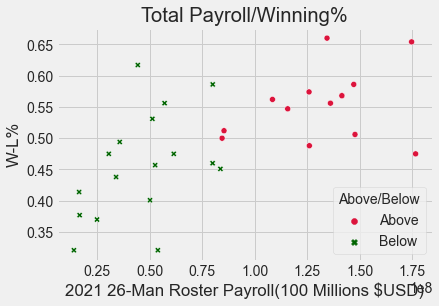

In [34]:
sns.set_style('ticks')
plt.style.use('fivethirtyeight')
c_code={'Above':'crimson', 'Below':'darkgreen'}
a=sns.scatterplot(x=final_team_standings['26-Man Roster Payroll'],y=final_team_standings['W-L%'], data=final_team_standings, 
style=final_team_standings['Above/Below'],hue=final_team_standings['Above/Below'] ,palette=c_code)
a.set_title('Total Payroll/Winning%')
a.set(xlabel='2021 26-Man Roster Payroll(100 Millions $USD)')




In [35]:
ab=final_team_standings.loc[final_team_standings['Above/Below']=='Above']
bel=final_team_standings.loc[final_team_standings['Above/Below']=='Below']
ab=ab[:-1]


How many teams in total spent above/below the league average payroll?

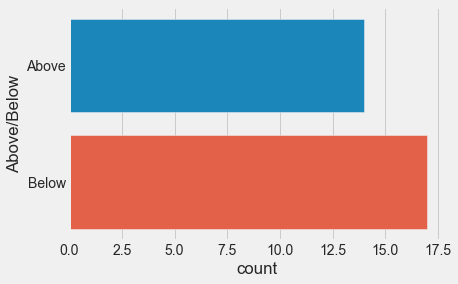

In [36]:
sns.countplot(y=final_team_standings['Above/Below'])
gen_per_ab = round(sum(ab['W-L%'])/len(ab['W-L%']), 3)
gen_per_bel = round(sum(bel['W-L%'])/len(bel['W-L%']), 3)

In [37]:
ab

Tm    W   L   W-L%    GB 2021 Total Payroll  \
17          New York Mets   77  85  0.475  11.5       $201,189,189   
13    Los Angeles Dodgers  106  56  0.654   1.0       $266,020,809   
20  Philadelphia Phillies   82  80  0.506   6.5       $197,213,223   
10         Houston Astros   95  67  0.586    --       $194,472,041   
18       New York Yankees   92  70  0.568   8.0       $205,669,863   
3          Boston Red Sox   92  70  0.568   8.0       $187,100,784   
25    St. Louis Cardinals   90  72  0.556   5.0       $171,469,994   
23   San Francisco Giants  107  55  0.660    --       $171,890,308   
22       San Diego Padres   79  83  0.488  28.0       $179,764,272   
5       Chicago White Sox   93  69  0.574    --       $140,926,169   
1          Atlanta Braves   88  73  0.547    --       $153,060,458   
28      Toronto Blue Jays   91  71  0.562   9.0       $150,140,253   
6         Cincinnati Reds   83  79  0.512  12.0       $126,587,447   

     IR Payroll  26-Man Roster Payroll Retained Payroll Buried Payroll  \
17  $11,933,570              176565754       $9,524,946    $12,006,000   
13  $38,501,103              174661542       $6,150,521    $24,070,000   
20  $19,936,225              147714046      $13,803,916    $10,533,500   
10  $39,870,546              147127725       $4,134,205     $7,547,600   
18  $48,217,362              141518753      $12,129,712    $13,040,875   
3    $2,832,729              141452731      $41,374,493    $10,227,500   
25  $14,512,682              136018560      $19,759,129     $5,171,100   
23  $19,766,740              134386796      $12,958,219    $16,549,200   
22  $49,745,500              125977584       $2,546,516     $6,926,300   
5    $3,193,240              125829369      $10,099,143     $5,997,000   
1    $3,301,950              115664387      $17,732,404     $8,925,000   
28   $8,853,529              108402749      $28,315,121     $9,968,100   
6   $35,531,500               85325437       $4,226,409     $5,156,000   

   Suspended Payroll Above/Below  
17                0-       Above  
13                0-       Above  
20                0-       Above  
10                0-       Above  
18                0-       Above  
3                 0-       Above  
25                0-       Above  
23                0-       Above  
22                0-       Above  
5                 0-       Above  
1                 0-       Above  
28                0-       Above  
6                 0-       Above

Average winning percentage for teams spending above the league average payroll 

In [38]:
gen_per_ab

0.558

Average winning percentage for teams spending below the league average payroll

In [39]:
gen_per_bel

0.456

Now let's evaluate the payrolls only for the teams that finished with a winning record.

The "--" value indicates a division winning team in the GB(Games Behind column)

In [40]:
f_team_winning=final_team_standings.loc[final_team_standings['W-L%']>.5]
f_team_winning

Tm    W   L   W-L%    GB 2021 Total Payroll  \
13    Los Angeles Dodgers  106  56  0.654   1.0       $266,020,809   
20  Philadelphia Phillies   82  80  0.506   6.5       $197,213,223   
10         Houston Astros   95  67  0.586    --       $194,472,041   
18       New York Yankees   92  70  0.568   8.0       $205,669,863   
3          Boston Red Sox   92  70  0.568   8.0       $187,100,784   
25    St. Louis Cardinals   90  72  0.556   5.0       $171,469,994   
23   San Francisco Giants  107  55  0.660    --       $171,890,308   
5       Chicago White Sox   93  69  0.574    --       $140,926,169   
1          Atlanta Braves   88  73  0.547    --       $153,060,458   
28      Toronto Blue Jays   91  71  0.562   9.0       $150,140,253   
6         Cincinnati Reds   83  79  0.512  12.0       $126,587,447   
15      Milwaukee Brewers   95  67  0.586    --        $99,377,415   
24       Seattle Mariners   90  72  0.556   5.0        $83,837,448   
19      Oakland Athletics   86  76  0.531   9.0        $90,400,598   
26         Tampa Bay Rays  100  62  0.617    --        $70,836,327   

     IR Payroll  26-Man Roster Payroll Retained Payroll Buried Payroll  \
13  $38,501,103              174661542       $6,150,521    $24,070,000   
20  $19,936,225              147714046      $13,803,916    $10,533,500   
10  $39,870,546              147127725       $4,134,205     $7,547,600   
18  $48,217,362              141518753      $12,129,712    $13,040,875   
3    $2,832,729              141452731      $41,374,493    $10,227,500   
25  $14,512,682              136018560      $19,759,129     $5,171,100   
23  $19,766,740              134386796      $12,958,219    $16,549,200   
5    $3,193,240              125829369      $10,099,143     $5,997,000   
1    $3,301,950              115664387      $17,732,404     $8,925,000   
28   $8,853,529              108402749      $28,315,121     $9,968,100   
6   $35,531,500               85325437       $4,226,409     $5,156,000   
15   $3,109,474               79937621      $10,266,654    $12,221,766   
24  $16,037,933               57025609       $8,004,079     $8,276,000   
19  $34,397,095               51210210       $2,500,111     $4,158,000   
26  $18,352,159               44288651       $6,218,025     $7,136,100   

   Suspended Payroll Above/Below  
13                0-       Above  
20                0-       Above  
10                0-       Above  
18                0-       Above  
3                 0-       Above  
25                0-       Above  
23                0-       Above  
5                 0-       Above  
1                 0-       Above  
28                0-       Above  
6                 0-       Above  
15                0-       Below  
24          $570,500       Below  
19          $580,500       Below  
26                0-       Below

The countplot below tallies the number of winning teams that spent above/below the mean total payroll 

<AxesSubplot:xlabel='count', ylabel='Above/Below'>

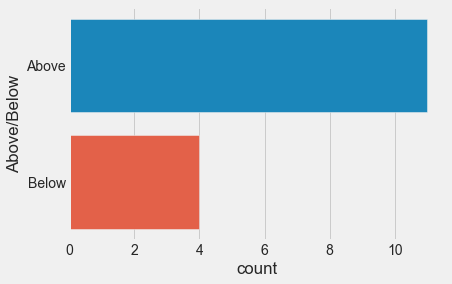

In [41]:
sns.countplot(y=f_team_winning['Above/Below'])

In [42]:
f_team_abwin=f_team_winning.loc[f_team_winning['Above/Below']=='Above']
win_per_ab = round(sum(f_team_abwin['W-L%'])/len(f_team_abwin['W-L%']),3)
f_team_abwin

Tm    W   L   W-L%    GB 2021 Total Payroll  \
13    Los Angeles Dodgers  106  56  0.654   1.0       $266,020,809   
20  Philadelphia Phillies   82  80  0.506   6.5       $197,213,223   
10         Houston Astros   95  67  0.586    --       $194,472,041   
18       New York Yankees   92  70  0.568   8.0       $205,669,863   
3          Boston Red Sox   92  70  0.568   8.0       $187,100,784   
25    St. Louis Cardinals   90  72  0.556   5.0       $171,469,994   
23   San Francisco Giants  107  55  0.660    --       $171,890,308   
5       Chicago White Sox   93  69  0.574    --       $140,926,169   
1          Atlanta Braves   88  73  0.547    --       $153,060,458   
28      Toronto Blue Jays   91  71  0.562   9.0       $150,140,253   
6         Cincinnati Reds   83  79  0.512  12.0       $126,587,447   

     IR Payroll  26-Man Roster Payroll Retained Payroll Buried Payroll  \
13  $38,501,103              174661542       $6,150,521    $24,070,000   
20  $19,936,225              147714046      $13,803,916    $10,533,500   
10  $39,870,546              147127725       $4,134,205     $7,547,600   
18  $48,217,362              141518753      $12,129,712    $13,040,875   
3    $2,832,729              141452731      $41,374,493    $10,227,500   
25  $14,512,682              136018560      $19,759,129     $5,171,100   
23  $19,766,740              134386796      $12,958,219    $16,549,200   
5    $3,193,240              125829369      $10,099,143     $5,997,000   
1    $3,301,950              115664387      $17,732,404     $8,925,000   
28   $8,853,529              108402749      $28,315,121     $9,968,100   
6   $35,531,500               85325437       $4,226,409     $5,156,000   

   Suspended Payroll Above/Below  
13                0-       Above  
20                0-       Above  
10                0-       Above  
18                0-       Above  
3                 0-       Above  
25                0-       Above  
23                0-       Above  
5                 0-       Above  
1                 0-       Above  
28                0-       Above  
6                 0-       Above

In [43]:
f_team_belwin=f_team_winning.loc[f_team_winning['Above/Below']=='Below']
win_per_bel = round(sum(f_team_belwin['W-L%'])/len(f_team_belwin['W-L%']), 3)
f_team_belwin

Tm    W   L   W-L%   GB 2021 Total Payroll   IR Payroll  \
15  Milwaukee Brewers   95  67  0.586   --        $99,377,415   $3,109,474   
24   Seattle Mariners   90  72  0.556  5.0        $83,837,448  $16,037,933   
19  Oakland Athletics   86  76  0.531  9.0        $90,400,598  $34,397,095   
26     Tampa Bay Rays  100  62  0.617   --        $70,836,327  $18,352,159   

    26-Man Roster Payroll Retained Payroll Buried Payroll Suspended Payroll  \
15               79937621      $10,266,654    $12,221,766                0-   
24               57025609       $8,004,079     $8,276,000          $570,500   
19               51210210       $2,500,111     $4,158,000          $580,500   
26               44288651       $6,218,025     $7,136,100                0-   

   Above/Below  
15       Below  
24       Below  
19       Below  
26       Below

Winning %'s for winning teams that spent above/below the league average payroll:

In [44]:
win_per_ab

0.572

In [45]:
win_per_bel

0.573

In [46]:
win_per_ab-win_per_bel

-0.0010000000000000009

There is essentially no difference in winning% for the winning teams that spent above/below the average 26-man payroll in 2021. Although, our sample sizes are uneven 

However, there are still 4 teams that finished with a winning record while spending below the league average payroll 

We will now determine the statistical criteria most instrumental in the success of these four teams for hitting, pitching, and defense 

Then we will compare those insights with the same for the teams finishing above .500 and spending above the league average payroll 

First let's look at hitting:


The ultimate goal with hitting is to score as many runs as possible to support your pitching 

Let's evaluate the realtionship between various hitting metrics and runs scored using a correlation matrix:

In [47]:
batbel=df_teambat.loc[(df_teambat.index=='Milwaukee Brewers')|(df_teambat.index=='Oakland Athletics')|(df_teambat.index=='Seattle Mariners')|(df_teambat.index=='Tampa Bay Rays')]
pays=list(f_team_belwin['26-Man Roster Payroll'])
win=list(f_team_belwin['W-L%'])
batbel['Payrolls']=pays
batbel['Winning%']=win
batbel.drop(labels='G', axis=1, inplace=True)
batbel

C:\Users\Brent Adelhoch\AppData\Local\Temp\ipykernel_3576\3547816159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batbel['Payrolls']=pays
C:\Users\Brent Adelhoch\AppData\Local\Temp\ipykernel_3576\3547816159.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batbel['Winning%']=win
C:\Users\Brent Adelhoch\AppData\Local\Temp\ipykernel_3576\3547816159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

#Bat  BatAge   R/G      PA      AB      R       H     2B  \
Milwaukee Brewers  61.0    28.7  4.56  6099.0  5362.0  738.0  1251.0  255.0   
Oakland Athletics  50.0    30.1  4.59  6104.0  5395.0  743.0  1284.0  271.0   
Seattle Mariners   63.0    27.0  4.30  6010.0  5355.0  697.0  1209.0  233.0   
Tampa Bay Rays     61.0    27.7  5.29  6213.0  5507.0  857.0  1336.0  288.0   

                     3B     HR    RBI    SB    CS     BB      SO     BA  \
Milwaukee Brewers  18.0  194.0  700.0  82.0  21.0  586.0  1465.0  0.233   
Oakland Athletics  19.0  199.0  698.0  88.0  20.0  545.0  1349.0  0.238   
Seattle Mariners   11.0  199.0  673.0  64.0  24.0  535.0  1492.0  0.226   
Tampa Bay Rays     36.0  222.0  810.0  88.0  42.0  585.0  1542.0  0.243   

                     OBP    SLG    OPS   OPS+      TB    GDP   HBP    SH  \
Milwaukee Brewers  0.317  0.396  0.713   92.0  2124.0  102.0  88.0  25.0   
Oakland Athletics  0.317  0.406  0.723  102.0  2190.0   99.0  98.0  17.0   
Seattle Mariners   0.303  0.385  0.688   92.0  2061.0   92.0  72.0   9.0   
Tampa Bay Rays     0.321  0.429  0.750  110.0  2362.0   75.0  72.0   6.0   

                     SF   IBB     LOB  Payrolls  Winning%  
Milwaukee Brewers  35.0  26.0  1113.0  79937621     0.586  
Oakland Athletics  49.0  17.0  1084.0  57025609     0.556  
Seattle Mariners   36.0   8.0  1040.0  51210210     0.531  
Tampa Bay Rays     41.0  27.0  1085.0  44288651     0.617

We will parse the statistical categories into groups of 4 and evaluate the correlations with winning percentage

<AxesSubplot:>

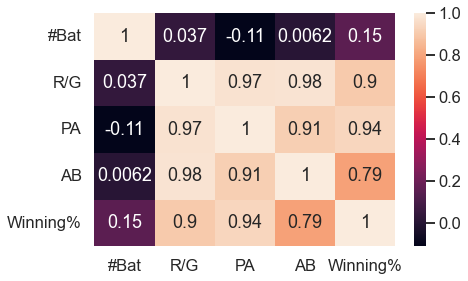

In [48]:
hitting1=batbel[['#Bat','R/G', 'PA','AB', 'Winning%']]
hitting1=hitting1.corr()
sns.set_style('darkgrid')
sns.set_context('talk')
sns.heatmap(hitting1, annot=True)



visual interpretation/findings:

The number of different hitters used had the highest correlation with winning for this set of statistics

Using my knowledge of baseball, this allows for a more diverse group of hitting abilities to be used, such as power, contact, speed, patience, etc., and some of these attibutes may be more effectual in certain situations. It doesn't necessarily take more spending power to do this. 

This is a more subtle factor than R/G(runs per game). Runs are the most obvious and direct contributor to offensive success in baseball, and statistics like Runs Batted In(RBIs), Home Runs(HRs), and Runs scored(R), among others, are what garner the most attention in free agency. Teams with more spending resources have a higher chance of acquiring these players in free agency 

Now let's look at the relationship between winning% and the other metrics in the data:



<AxesSubplot:>

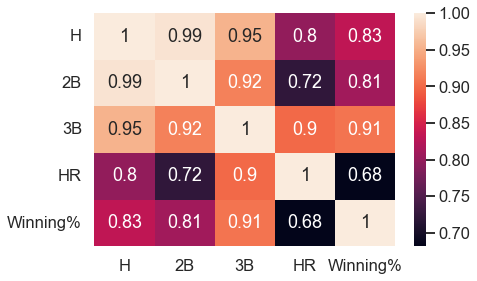

In [49]:
hitting1=batbel[['H', '2B', '3B', 'HR', 'Winning%']]
hitting1=hitting1.corr()
sns.heatmap(hitting1, annot=True)

Triples(3B) have the highest correlation with winning and production in this area alone wouldn't draw much attention in free agency 

Triples compose a bigger metric called extra base hits(the aggregate of doubles, triples, and home runs) which would draw attention in free agency 

Triples are more frequent with faster players, and speed alone is not difficult to acquire. Speed coupled with contact hitting abilites is more rare and cost more resources(money, high draft 
picks, minor league prospects, etc.) to acquire

<AxesSubplot:>

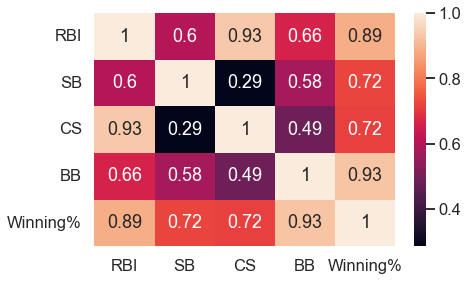

In [50]:
hitting1=batbel[['RBI','SB','CS','BB', 'Winning%']]
hitting1=hitting1.corr()
sns.heatmap(hitting1, annot=True)


The notable correlations with winning % in this map are with stolen bases/caught steeling and walks

RBIs have a positive correlation with winning but this is expected as they directly contribute to runs scored therefore making them a valued attribute in free agency and the trade market. Hence larger markets hava a better chance of acquiring these players once available 

The more important ones to focus on are Stolen Bases(SB), Caught Steeling(CS), and Walks(BB)

Stolen bases and caught steeling are the direct result of being strategic and having speed on the team. Walks are the result of good pitch selection. these three statistics, when consolidated, are great for indirectly manufacturing runs 

<AxesSubplot:>

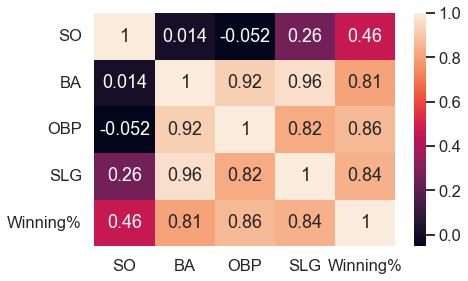

In [51]:
hitting1=batbel[['SO', 'BA', 'OBP', 'SLG', 'Winning%']]
hitting1=hitting1.corr()
sns.heatmap(hitting1, annot=True)

This plot is a bit trickier. The basic assumption is that strikeouts are the least productive type of out and should be avoided at all costs.

However, in certain situations, striking out may be better than putting the ball in play. For instance, if the bases are loaded with one out in a given inning, striking out is a better alternative than hitting a ground ball because it can result in a double play and end the inning. Striking out would keep the inning alive and possibly give a better hitter a chance at driving the runs in 

Therefore, having a high percentage of outs made on strikeouts can ironically be beneficial in certain situations 

<AxesSubplot:>

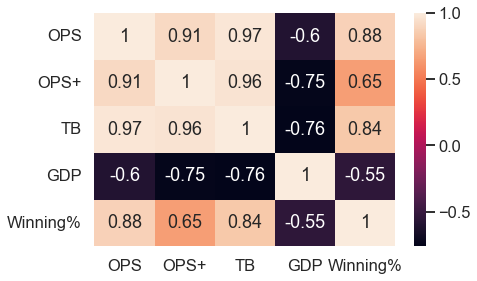

In [52]:
hitting1=batbel[['OPS', 'OPS+','TB','GDP', 'Winning%']]
hitting1=hitting1.corr()
sns.heatmap(hitting1, annot=True)

The only significant correlations are with OPS+ and GDP(# of double plays grounded into)

OPS+ is the sum of on-base and slugging% adjusted for the ballpark the player played in and the league(NationalAmerican) for which he played in

The other notable corrlation is with GDP as they have a negative correlation

This finding provides some justification for the positive relationship between winning% and team strikeouts

Double plays will be overlooked if a player still produces in major statistical categories(HR, RBI, SLG, OBP, OPS, BA)

Text(0.5, 1.0, 'Winning Percentage Correlations ')

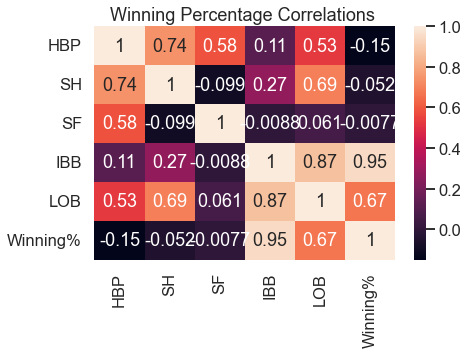

In [53]:
hitting1=batbel[['HBP', 'SH', 'SF', 'IBB', 'LOB', 'Winning%']]
hitting1=hitting1.corr()
a=sns.heatmap(hitting1, annot=True)
a.set_title('Winning Percentage Correlations ')

Managers initiate intentional walks(IBB), and hitters obviously cannot control getting hit by pitches. Sacrifice hits are sometimes instigated by the manager. Sacrifice flys score runs but they are still outs and the hitter does not intend to hit them 

HBP can have a negative realtionship with winning for certain reasons such as resulting injuries, not getting a chance to put the ball in play, etc.

Nonetheless, the map shows that sacrifice hits and flys are not instrumental in winning among these teams, perhaps because putting the ball in play increases the chances of multiple runners scoring 

Intentional Base on Balls(IBB) is the result of productive hitters being walked for situational reasons 


Now lets look at the same correlations for winning teams that spent above the league average payroll 

In [54]:
batab=df_teambat.loc[(df_teambat.index=='Los Angeles Dodgers')|(df_teambat.index=='New York Yankees')|(df_teambat.index=='Philadelphia Phillies')|(df_teambat.index=='Houston Astros')|
(df_teambat.index=='Boston Red Sox')|(df_teambat.index=='San Francisco Giants')|(df_teambat.index=='St. Louis Cardinals')|(df_teambat.index=='Atlanta Braves')|
(df_teambat.index=='Toronto Blue Jays')|(df_teambat.index=='Chicago White Sox')|(df_teambat.index=='Cincinnati Reds')]
pays=list(f_team_abwin['26-Man Roster Payroll'])
win=list(f_team_abwin['W-L%'])
batab['Payrolls']=pays
batab['Winning%']=win
batab.drop(labels='G', axis=1, inplace=True)
batab

C:\Users\Brent Adelhoch\AppData\Local\Temp\ipykernel_3576\1419002796.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batab['Payrolls']=pays
C:\Users\Brent Adelhoch\AppData\Local\Temp\ipykernel_3576\1419002796.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batab['Winning%']=win
C:\Users\Brent Adelhoch\AppData\Local\Temp\ipykernel_3576\1419002796.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

#Bat  BatAge   R/G      PA      AB      R       H  \
Atlanta Braves         56.0    28.2  4.91  6056.0  5363.0  790.0  1307.0   
Boston Red Sox         56.0    28.0  5.12  6122.0  5495.0  829.0  1434.0   
Chicago White Sox      47.0    28.0  4.91  6084.0  5357.0  796.0  1373.0   
Cincinnati Reds        55.0    28.9  4.85  6162.0  5423.0  786.0  1352.0   
Houston Astros         52.0    28.9  5.33  6291.0  5593.0  863.0  1496.0   
Los Angeles Dodgers    61.0    29.2  5.12  6239.0  5445.0  830.0  1330.0   
New York Yankees       59.0    29.3  4.39  6060.0  5331.0  711.0  1266.0   
Philadelphia Phillies  55.0    29.1  4.53  6089.0  5366.0  734.0  1288.0   
San Francisco Giants   54.0    30.6  4.96  6196.0  5462.0  804.0  1360.0   
St. Louis Cardinals    51.0    28.5  4.36  6001.0  5351.0  706.0  1303.0   
Toronto Blue Jays      62.0    26.8  5.22  6070.0  5476.0  846.0  1455.0   

                          2B    3B     HR    RBI    SB    CS     BB      SO  \
Atlanta Braves         269.0  20.0  239.0  762.0  59.0  19.0  549.0  1453.0   
Boston Red Sox         330.0  23.0  219.0  783.0  40.0  21.0  512.0  1386.0   
Chicago White Sox      275.0  22.0  190.0  757.0  57.0  20.0  586.0  1389.0   
Cincinnati Reds        295.0  13.0  222.0  756.0  36.0  24.0  553.0  1425.0   
Houston Astros         299.0  14.0  221.0  834.0  53.0  16.0  569.0  1222.0   
Los Angeles Dodgers    247.0  24.0  237.0  799.0  65.0  17.0  613.0  1408.0   
New York Yankees       213.0  12.0  222.0  666.0  63.0  18.0  621.0  1482.0   
Philadelphia Phillies  262.0  24.0  198.0  700.0  77.0  19.0  564.0  1402.0   
San Francisco Giants   271.0  25.0  241.0  768.0  66.0  14.0  602.0  1461.0   
St. Louis Cardinals    261.0  22.0  198.0  678.0  89.0  22.0  478.0  1341.0   
Toronto Blue Jays      285.0  13.0  262.0  816.0  81.0  20.0  496.0  1218.0   

                          BA    OBP    SLG    OPS   OPS+      TB    GDP  \
Atlanta Braves         0.244  0.319  0.435  0.754   98.0  2333.0   81.0   
Boston Red Sox         0.261  0.328  0.449  0.777  106.0  2467.0  100.0   
Chicago White Sox      0.256  0.336  0.422  0.758  106.0  2262.0  139.0   
Cincinnati Reds        0.249  0.328  0.431  0.759   95.0  2339.0  129.0   
Houston Astros         0.267  0.339  0.444  0.783  113.0  2486.0  136.0   
Los Angeles Dodgers    0.244  0.330  0.429  0.759  101.0  2336.0   96.0   
New York Yankees       0.237  0.322  0.407  0.729  100.0  2169.0  154.0   
Philadelphia Phillies  0.240  0.318  0.408  0.726   95.0  2192.0  103.0   
San Francisco Giants   0.249  0.329  0.440  0.769  107.0  2404.0  117.0   
St. Louis Cardinals    0.244  0.313  0.412  0.725   99.0  2202.0   99.0   
Toronto Blue Jays      0.266  0.330  0.466  0.797  113.0  2552.0  112.0   

                         HBP    SH    SF   IBB     LOB   Payrolls  Winning%  
Atlanta Braves          67.0  32.0  43.0  36.0  1072.0  174661542     0.654  
Boston Red Sox          61.0  10.0  42.0  22.0  1093.0  147714046     0.506  
Chicago White Sox       78.0  24.0  39.0  10.0  1125.0  147127725     0.586  
Cincinnati Reds        105.0  35.0  45.0  22.0  1110.0  141518753     0.568  
Houston Astros          64.0   9.0  54.0  25.0  1159.0  141452731     0.568  
Los Angeles Dodgers    104.0  32.0  45.0  36.0  1169.0  136018560     0.556  
New York Yankees        63.0  10.0  34.0  14.0  1097.0  134386796     0.660  
Philadelphia Phillies   67.0  47.0  43.0  37.0  1115.0  125829369     0.574  
San Francisco Giants    64.0  36.0  30.0  45.0  1138.0  115664387     0.547  
St. Louis Cardinals     86.0  40.0  44.0  32.0  1081.0  108402749     0.562  
Toronto Blue Jays       51.0  10.0  35.0  14.0  1056.0   85325437     0.512

<AxesSubplot:>

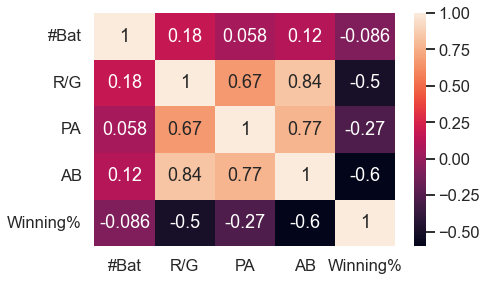

In [55]:
hitting1=batab[['#Bat','R/G', 'PA','AB', 'Winning%']]
hitting1=hitting1.corr()
sns.heatmap(hitting1, annot=True)

The only significant correlation here is between winning% and the number of batters used 

Although the correlation is not as strong as it is with smaller market teams, it is another instance of how diversfiying skillsets reaps benefits 

The slightly higher correlation with small markets may imply that it is more crucial for those teams to do this well because they have a harder time signing players that more directly contribute to scoring runs in the more prominent offensive categories already mentioned 

the other three negative correlations are relatively close to zero and is likely linked to poor pitching and fielding 

<AxesSubplot:>

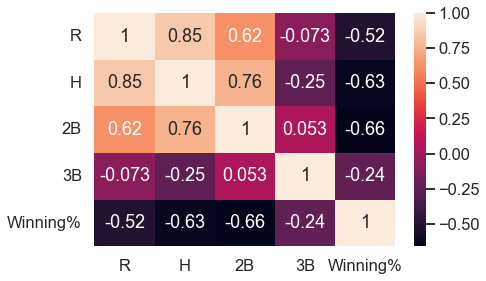

In [56]:
hitting1=batab[['R', 'H', '2B', '3B', 'Winning%']]
hitting1=hitting1.corr()
sns.heatmap(hitting1, annot=True)

There are no significant correlations in this heatmap. 

Don't be fooled by the negative correlations between Runs, Hits, and Doubles. Offensive production is obviously important but futile with poor pitching/defense.

Let's move on to the next group 

<AxesSubplot:>

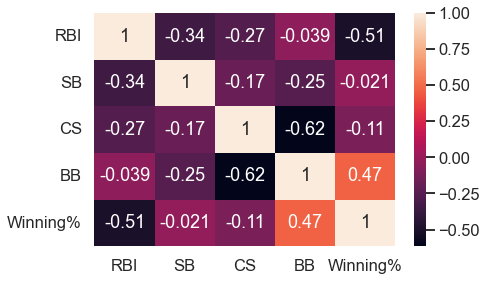

In [57]:
hitting1=batab[['RBI','SB','CS','BB', 'Winning%']]
hitting1=hitting1.corr()
sns.heatmap(hitting1, annot=True)

The slight positive correlation with walks is worth noting. 

Walks do more than just give free baserunners. They make the opposing pitching staff throw more pitches and expend more of their bullpen.

When pitchers limit walks, they throw fewer pitches, allowing them to pitch deeper into games, and keep their bullpen rested for upcoming games 

<AxesSubplot:>

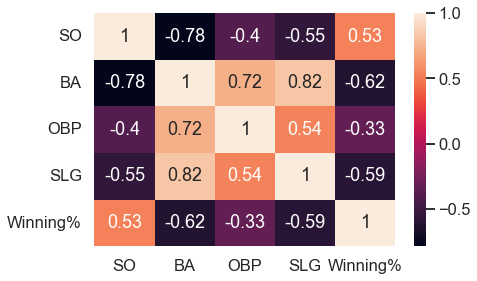

In [58]:
hitting1=batab[['SO', 'BA', 'OBP', 'SLG', 'Winning%']]
hitting1=hitting1.corr()
sns.heatmap(hitting1, annot=True)

Although not as strong, the same interesting correlation exists between strikeouts and winning percentage 

Again, this is likely because it is a better alternative to putting the ball in play in many run producing situations

<AxesSubplot:>

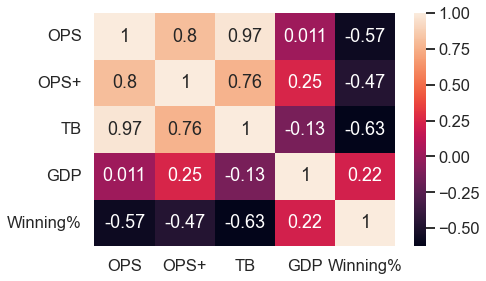

In [59]:
hitting1=batab[['OPS', 'OPS+','TB','GDP', 'Winning%']]
hitting1=hitting1.corr()
sns.heatmap(hitting1, annot=True)

There are no correlations worth touching on here. Again, OPS(On-Base plus Slugging Percentage), OPS+(Adjusted OPS) and TB(Total Bases) are all important for producing runs, but producing in these areas means nothing if a team has poor pitching and/or defense. 

<AxesSubplot:>

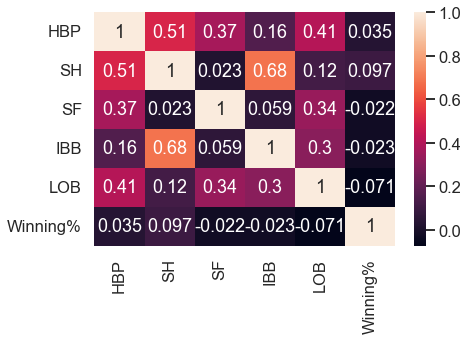

In [60]:
hitting1=batab[['HBP', 'SH', 'SF', 'IBB', 'LOB', 'Winning%' ]]
hitting1=hitting1.corr()
sns.heatmap(hitting1, annot=True)

The correlations with these statistics aren't that important because, as already noted, many of these are things players can't control 

They may not be important when it comes to evaluating players, but maybe when hiring managers


Breakdown of hitting analysis:

There is not much difference between the statistics that hold positive correlations for both categories of winning teams

However, certain correlations are stronger for the smaller market teams, meaning it is more crucial for these teams to produce in these areas

These statistics are strikeouts, # of batters used, triples, stolen bases, and walks

The correlation between the # of batters used and winning perentage tells us that managers who use the diverse offensive skillsets on their rosters in suitable situations see more success, and it is even more important for small market teams to do this because more comprehensive skillsets cost more to acquire.

In short, small market teams should acquire diverse hitters that can contribute immensely in a certain category(HR, Stolen Bases, Triples, walks) regardless of their production in others

While they should diversify across all statistical hitting categories, small market teams should certainly be rich in these skillsets: speed, patience/vision at the plate, making outs with strikeouts, and contact 



